<a href="https://colab.research.google.com/github/Kan-0102/DCGAN/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


# トレーニングのバッチサイズ
batch_size = 32

# データローダーのワーカー数
workers = 2

#クラス 数
label_class = 1

ngpu = 1

#生成器モデルチャネル数(入力次元数100次元　＋　データセットのクラス数)
noise_sum = 100

#識別機モデルチャネル数(1(出力)　＋　データセットのクラス数)
dtensor_num = 1

In [ ]:
# 画像のoverview保存先のパス
outf = '/content/drive/MyDrive/3_GeneratedImageOverview/MalImag_Dataset'

# 画像の保存先のパス
out_d = '/content/drive/MyDrive/2.1_malimg_paper_dataset_imgs'

# データセットのルートディレクトリ(補間済み)
dataroot = "/content/drive/MyDrive/malimg_paper_dataset_imgs_bicubic"

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([32, 1, 64, 64])


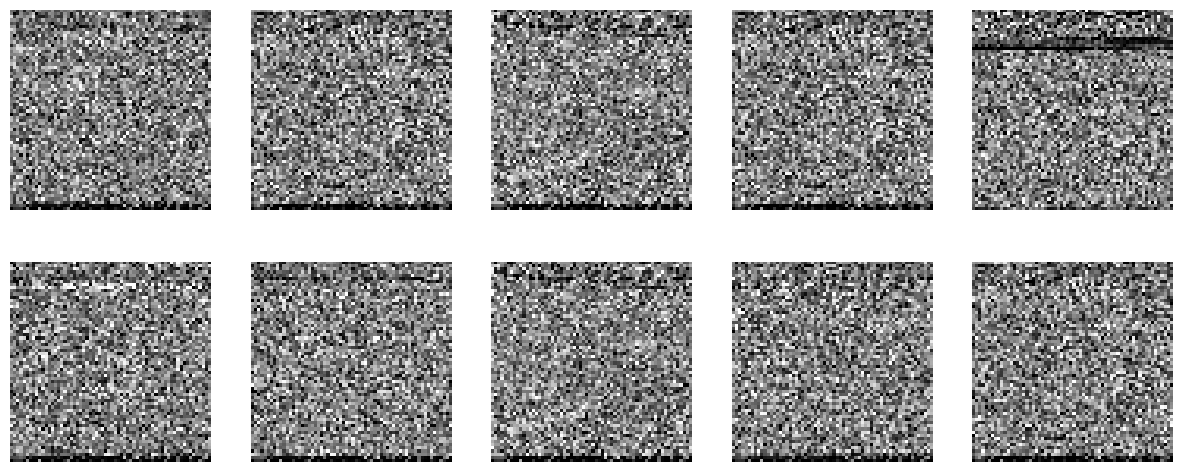

In [ ]:
from torch.utils.data import Dataset, DataLoader

from PIL import Image

class OneClassDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_name).convert("L")  # グレースケールに変換

        if self.transform:
            image = self.transform(image)

        # バッチサイズの次元を追加
        image = image.unsqueeze(0)

        # バッチサイズを20に変更
        image = image.expand(batch_size, -1, -1, -1)

        return image

# トランスフォームを設定
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

one_class_dataset = OneClassDataset(root_dir=dataroot, transform=transform)
# データローダーを作成
dataloader = DataLoader(one_class_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Set the device for processing
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


real_batch = next(iter(dataloader))
print(real_batch[0].shape)

# Get 10 random indices from the dataset
indices = torch.randint(0, len(one_class_dataset), (10,))

# Fetch and display the images
plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices):
    img_name = os.path.join(one_class_dataset.root_dir, one_class_dataset.file_list[idx])
    image = Image.open(img_name).convert("L")

    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.show()

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        start_ch = 64  # 出力チャネル数を減らす
        in_ch = 1

        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, start_ch, 3, 2, 1),
                nn.Dropout(0.5),
                nn.LeakyReLU(0.2)
            ),
            nn.Sequential(
                nn.Conv2d(start_ch, start_ch * 2, 3, 2, 1),
                nn.BatchNorm2d(start_ch * 2),
                nn.Dropout(0.5),
                nn.LeakyReLU(0.2)
            ),
            nn.Sequential(
                nn.Conv2d(start_ch * 2, start_ch * 4, 3, 2, 1),
                nn.BatchNorm2d(start_ch * 4),
                nn.Dropout(0.5),
                nn.LeakyReLU(0.2)
            ),
            nn.Sequential(
                nn.Conv2d(start_ch * 4, 1, 3, 1, 0),  # ストライドを1、パディングを0に変更
                nn.AdaptiveAvgPool2d(1),  # AdaptiveAvgPool2dを使って出力サイズを[1, 1]に変更
                nn.Sigmoid()
            )
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x.squeeze()


In [ ]:
'''
3. 生成器のクラスを定義　5層
'''
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        input_dim = 100 # 入力データの次元
        out_ch = 128       # 最終層のチャネル数
        img_ch = 1         # 生成画像のチャネル数

        self.layers = nn.ModuleList([
            # 第1層: (bs, 110, 1, 1) -> (bs, 512, 3, 3)
            nn.Sequential(
                nn.ConvTranspose2d(input_dim, out_ch * 4, 4, 1, 0),         # パディングは0(なし)
                # 出力値を正規化する(チャネル数は128×4)
                nn.BatchNorm2d(out_ch * 4),
                # ReLU関数を適用
                nn.LeakyReLU()
            ),
             # 第2層: (bs, 512, 3, 3) -> (bs, 256, 7, 7)
            nn.Sequential(
                nn.ConvTranspose2d(out_ch * 4, out_ch * 2, 4,2, 1),
                nn.BatchNorm2d(out_ch * 2),
                nn.LeakyReLU()
            ),
             # 第3層: (bs, 256, 7, 7) -> (bs, 128, 14, 14)
            nn.Sequential(
                nn.ConvTranspose2d(out_ch * 2,out_ch, 4, 2, 1),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU()
            ),
             # 第4層: (bs, 128, 16, 16) -> (bs, 64, 32, 32)
            nn.Sequential(
                nn.ConvTranspose2d(out_ch,  64, 4, 2, 1),
                nn.BatchNorm2d(64),
                #nn.Dropout(0.5),   # ドロップアウト
                nn.LeakyReLU()
            ),
             # 第5層: (bs, 64, 32, 32) -> (bs, 1, 64, 64)
            nn.Sequential(
                nn.ConvTranspose2d(64,img_ch, 4, 2, 1),
                nn.Tanh()
            )
        ])

    def forward(self, z):
        '''順伝播処理

        Parameter:
          z: 識別器の出力
        '''
        # 生成器のネットワークに入力して順伝播する
        for layer in self.layers:
            z = layer(z)
        return z

In [ ]:
'''
3. 生成器のクラスを定義
'''
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        input_dim = 100 # 入力データの次元
        out_ch = 128       # 最終層のチャネル数
        img_ch = 1         # 生成画像のチャネル数

        self.layers = nn.ModuleList([
            # 第1層: (bs, 110, 1, 1) -> (bs, 512, 3, 3)
            nn.Sequential(
                nn.ConvTranspose2d(input_dim, out_ch * 2, 8, 1, 0),         # パディングは0(なし)
                # 出力値を正規化する(チャネル数は128×4)
                nn.BatchNorm2d(out_ch * 2),
                # ReLU関数を適用
                nn.LeakyReLU()
            ),
             # 第3層: (bs, 256, 7, 7) -> (bs, 128, 14, 14)
            nn.Sequential(
                nn.ConvTranspose2d(out_ch * 2,out_ch, 4, 2, 1),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU()
            ),
             # 第4層: (bs, 128, 16, 16) -> (bs, 64, 32, 32)
            nn.Sequential(
                nn.ConvTranspose2d(out_ch,  64, 4, 2, 1),
                nn.BatchNorm2d(64),
                #nn.Dropout(0.5),   # ドロップアウト
                nn.LeakyReLU()
            ),
             # 第5層: (bs, 64, 32, 32) -> (bs, 1, 64, 64)
            nn.Sequential(
                nn.ConvTranspose2d(64,img_ch, 4, 2, 1),
                nn.Tanh()
            )


        ])

    def forward(self, z):
        '''順伝播処理

        Parameter:
          z: 識別器の出力
        '''
        # 生成器のネットワークに入力して順伝播する
        for layer in self.layers:
            z = layer(z)
        return z

In [ ]:
'''
3. 生成器のクラスを定義　4層
'''
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        input_dim = 100 # 入力データの次元
        out_ch = 128       # 最終層のチャネル数
        img_ch = 1         # 生成画像のチャネル数

        self.layers = nn.ModuleList([
            # 第1層: (bs, 110, 1, 1) -> (bs, 512, 3, 3)
            nn.Sequential(
                nn.ConvTranspose2d(input_dim, out_ch * 2, 4, 2, 0),         # パディングは0(なし)
                # 出力値を正規化する(チャネル数は128×4)
                nn.BatchNorm2d(out_ch * 2),
                # ReLU関数を適用
                nn.LeakyReLU()
            ),
             # 第3層: (bs, 256, 7, 7) -> (bs, 128, 14, 14)
            nn.Sequential(
                nn.ConvTranspose2d(out_ch * 2,out_ch, 6, 2, 1),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU()
            ),
             # 第4層: (bs, 128, 16, 16) -> (bs, 64, 32, 32)
            nn.Sequential(
                nn.ConvTranspose2d(out_ch,  64, 6, 3, 1),
                nn.BatchNorm2d(64),
                #nn.Dropout(0.5),   # ドロップアウト
                nn.LeakyReLU()
            ),
             # 第5層: (bs, 64, 32, 32) -> (bs, 1, 64, 64)
            nn.Sequential(
                nn.ConvTranspose2d(64,img_ch, 6, 2, 1),
                nn.Tanh()
            )


        ])

    def forward(self, z):
        '''順伝播処理

        Parameter:
          z: 識別器の出力
        '''
        # 生成器のネットワークに入力して順伝播する
        for layer in self.layers:
            z = layer(z)
        return z

In [ ]:
'''
4. 重みの初期化を行う関数
'''
def weights_init(m):
    '''
    ネットワークの重みを正規分布からサンプリングした値で初期化する

    Parameters:
      m: ネットワークのインスタンス
    '''
    classname = m.__class__.__name__
    # 畳み込み層の重み
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02) # 平均0、標準偏差0.02の正規分布
        m.bias.data.fill_(0) # バイアスのみ0で初期化
    # バッチ正規化層の重み
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02) # 平均1.0、標準偏差0.02の正規分布
        m.bias.data.fill_(0) # バイアスのみ0で初期化

In [ ]:
'''
5. 生成器をインスタンス化して重みを初期化する
'''
import torchsummary

# 生成器をインスタンス化
generator = Generator().to(device)
# 重みを初期化
generator.apply(weights_init)
# 生成器のサマリを出力
torchsummary.summary(generator,
                     (noise_sum, 1, 1))  # 入力テンソルの形状

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,856
       BatchNorm2d-2            [-1, 256, 4, 4]             512
         LeakyReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4          [-1, 128, 10, 10]       1,179,776
       BatchNorm2d-5          [-1, 128, 10, 10]             256
         LeakyReLU-6          [-1, 128, 10, 10]               0
   ConvTranspose2d-7           [-1, 64, 31, 31]         294,976
       BatchNorm2d-8           [-1, 64, 31, 31]             128
         LeakyReLU-9           [-1, 64, 31, 31]               0
  ConvTranspose2d-10            [-1, 1, 64, 64]           2,305
             Tanh-11            [-1, 1, 64, 64]               0
Total params: 1,887,809
Trainable params: 1,887,809
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [ ]:
'''
6. 識別器をインスタンス化して重みを初期化する
'''
# 識別器をインスタンス化
discriminator = Discriminator().to(device)
# 重みを初期化
discriminator.apply(weights_init)
# 識別器のサマリを出力
torchsummary.summary(discriminator,
                     (dtensor_num, 64, 64))  # 入力テンソルの形状

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
           Dropout-2           [-1, 64, 32, 32]               0
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
       BatchNorm2d-5          [-1, 128, 16, 16]             256
           Dropout-6          [-1, 128, 16, 16]               0
         LeakyReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8            [-1, 256, 8, 8]         295,168
       BatchNorm2d-9            [-1, 256, 8, 8]             512
          Dropout-10            [-1, 256, 8, 8]               0
        LeakyReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12              [-1, 1, 6, 6]           2,305
AdaptiveAvgPool2d-13              [-1, 1, 1, 1]               0
          Sigmoid-14              [-1, 

In [ ]:
'''
7. 損失関数とオプティマイザーの設定
'''
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.utils import save_image

# 損失関数はバイナリクロスエントロピー誤差
criterion = nn.BCELoss()
# 識別器のオプティマイザ−を設定
optimizer_ds = optim.Adam(discriminator.parameters(),
                          lr=0.0001)  # 学習率: デフォルトは0.001
# 生成器のオプティマイザーを設定
optimizer_gn = optim.Adam(generator.parameters(),
                          lr=0.001)

#scheduler_ds = ReduceLROnPlateau(optimizer, 'min')
#scheduler_gn = ReduceLROnPlateau(optimizer_gn, 'min')

In [ ]:

import torchvision.utils as vutils
import torch.nn.functional as F
from torchvision.utils import save_image

In [ ]:
n_epoch = 5000  # 学習回数
noise_num = 100
fixed_noise = torch.randn(batch_size, # バッチサイズ
                          noise_num,  # ノイズの次元100
                          1,          # 1
                          1,          # 1
                          device=device)
G_losses = []
D_losses = []



# 学習のループ
for epoch in range(n_epoch):
    print('Epoch {}/{}'.format(epoch + 1, n_epoch))

    # バッチデータのループ(ステップ)
    for itr, real_image_batch in enumerate(dataloader):
        # ミニバッチのすべての画像を取得
        real_image = real_image_batch[0].to(device)

        # -----識別器の学習-----
        # オリジナル画像に対する識別信号の正解値「1」で初期化
        real_target = torch.full((batch_size,), 1., device=device)

        # 識別器の誤差の勾配を初期化
        discriminator.zero_grad()

        # 識別器にオリジナル画像を入力して識別信号を出力
        output = discriminator(real_image)

        # オリジナル画像に対する識別値の損失を取得
        ds_real_err = criterion(output, real_target)

        # 1ステップ(1バッチ)におけるオリジナル画像の識別信号の平均
        true_dsout_mean = output.mean().item()

        # ノイズからフェイク画像を生成
        noise = torch.randn(batch_size, noise_num, 1, 1, device=device)
        fake_image = generator(noise)

        # フェイク画像に対する識別信号の正解値「0」で初期化
        fake_target = torch.full((batch_size,), 0., device=device)

        # フェイク画像とフェイクラベルを識別器に入力して識別信号を出力
        output = discriminator(fake_image.detach())  # detachで生成器への勾配伝播を止める
        # フェイク画像を偽と判定できない場合の損失
        ds_fake_err = criterion(output, fake_target)
        # フェイク画像の識別信号の平均
        fake_dsout_mean = output.mean().item()
        # オリジナル画像とフェイク画像に対する識別の損失を合計して
        # 識別器としての損失を求める
        ds_err = ds_real_err + ds_fake_err

        # 識別器全体の誤差を逆伝播
        ds_err.backward()
        # 識別器の重みのみを更新(生成器は更新しない)
        optimizer_ds.step()

        # -----生成器の学習-----
        # 生成器の誤差の勾配を初期化
        generator.zero_grad()
        # フェイク画像に対する識別信号の正解値「1」で初期化
        real_target = torch.full((batch_size,), 1., device=device)

        # 更新後の識別器に再度フェイク画像を入力して識別信号を取得
        output = discriminator(fake_image)
        # フェイク画像をオリジナル画像と誤認できない場合の損失
        gn_err = criterion(output, real_target)
        # 更新後の識別器の誤差を逆伝播
        gn_err.backward()

        # 生成器の誤差を取得
        fake_dsout_mean2 = output.mean().item()

        # 生成器の重みを更新
        optimizer_gn.step()

        G_losses.append(gn_err.item())
        D_losses.append(ds_err.item())

        # 100ステップごとに出力
        if itr % 100 == 0:
            print(
                '({}/{}) ds_loss: {:.3f} - gn_loss: {:.3f} - true_out: {:.3f} - fake_out: {:.3f}>>{:.3f}'
                .format(
                    itr + 1,
                    len(dataloader),
                    ds_err.item(),    # 識別器の損失
                    gn_err.item(),    # 生成器の損失
                    true_dsout_mean,  # オリジナル画像の識別信号の平均
                    fake_dsout_mean,  # フェイク画像の識別信号の平均
                    fake_dsout_mean2) # 更新後識別器のフェイクの識別信号平均
            )

        # 学習開始直後にオリジナル画像を保存する
        if epoch == 0 and itr == 0:
            vutils.save_image(real_image,
                              '{}/real_samples.png'.format(outf),
                              normalize=True,
                              nrow=10)

    # 生成器の出力を保存
    if epoch % 50 == 0 or epoch == n_epoch:
        current_noise = torch.randn(batch_size, noise_num, 1, 1, device=device)
        fake_image = generator(current_noise)
        vutils.save_image(
            fake_image.detach(),
            '{}/fake_samples_epoch_{:03d}.png'.format(outf, epoch + 1),
            normalize=True,
            nrow=10)


In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from torchvision.utils import save_image
# 生成する画像の数
num_images_to_generate = 100

latent_dim = 100
noise = torch.randn(num_images_to_generate, latent_dim, 1, 1, device=device)

# 生成器による画像生成
with torch.no_grad():
    generated_images = generator(noise)


# 生成された画像を保存
for i in range(num_images_to_generate):
    save_image(generated_images[i], f'{out_d}/dgenerated_image_{i+1}.png', normalize=True)


In [ ]:
from google.colab import runtime
runtime.unassign()